# Overfitting and Underfitting in regularized Logistic Regression

Last class, Austin has shown different cases of the regulation parameter $\lambda$:
$$J_1(w)=J_0(w)+\frac{\lambda}{2}w^2$$

This time I am going to compare the cases of Overfitting and Underfitting in regularized logistic regression. Most of the code below is directly copied from Austin's jupyter notebook.

## Import

In [1]:
import numpy as np
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import model_selection,metrics,preprocessing,linear_model
from matplotlib.colors import ListedColormap
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from collections import Counter
%matplotlib inline

## Functions to draw figures

In [2]:
def versiontuple(v):
    return tuple(map(int, (v.split("."))))

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', '^', 'v')
    colors = ('red', 'blue',  'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    edgecolor='black',
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

## Generate the training data and test data

In [3]:
lamb = 5
my_c = 1.0/lamb
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
#class labels in sklearn are denoted by integers fyi. 

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,test_size=0.3,
                                                                    random_state=1,
                                                                    stratify=y)

## normalize data

In [4]:
sc = preprocessing.StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

## Plot the accuracy versus $\lambda^{-1}$

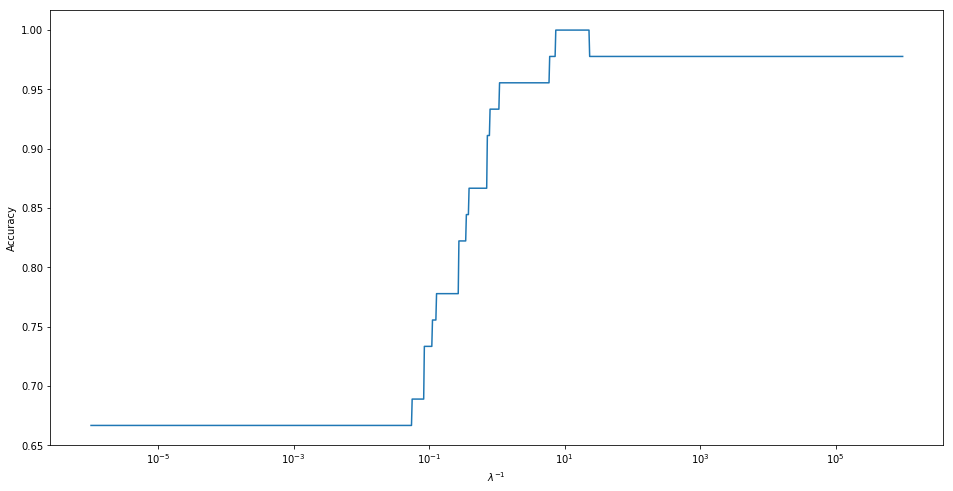

In [5]:
weights, params = [], []
accuracy = []
lrs = []

for c in np.arange(-599, 600)/100:
    lr = linear_model.LogisticRegression(C=10.**c, random_state=1)
    lr.fit(X_train_std, y_train)
    lrs.append(lr)
    weights.append(lr.coef_[1])
    params.append(10.**c)
    y_pred = lr.predict(X_test_std)
    acc = metrics.accuracy_score(y_test, y_pred)
    accuracy.append(acc)

    
weights = np.array(weights)

plt.close('all')
fig, axs= plt.subplots(1, 1, figsize=(16, 8))
plt.subplot(111)
plt.plot(params, accuracy)
plt.xlabel(r'$\lambda^{-1}$')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.show()

We can see in the left part of the plot, the $\lambda^{-1}$ is small, thus gives more penalty to the object function. Then model is stable, its variance is small. In such the case, the model is less sensitive to the dataset, which may cause underfitting.

#### Compare the underfitting case ($\lambda^{-1}=10^{-3}$), overfitting case ($\lambda^{-1}=10^{5}$) and the good case ($\lambda^{-1}=10^{1}$) 

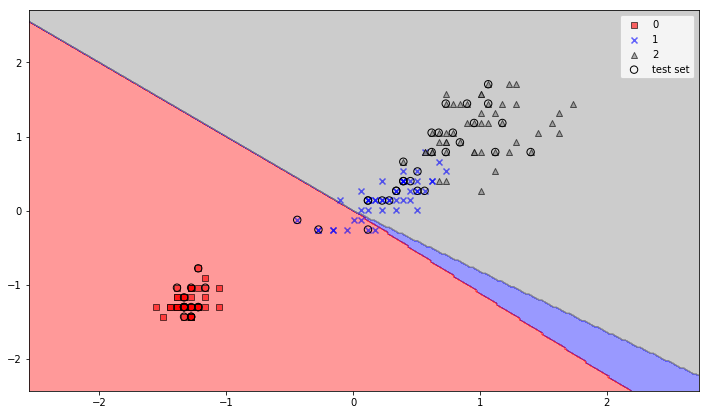

In [6]:
plt.figure(figsize=(12,7))
lr1 = linear_model.LogisticRegression(C=10.**(-3), random_state=1)
lr1.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr1, test_idx=range(105, 150))
plt.legend()

We could see for that underfitting case, we could see the regression hasn't distinguished different type of dataset well in the training. Thus the test result seems not to perform well.

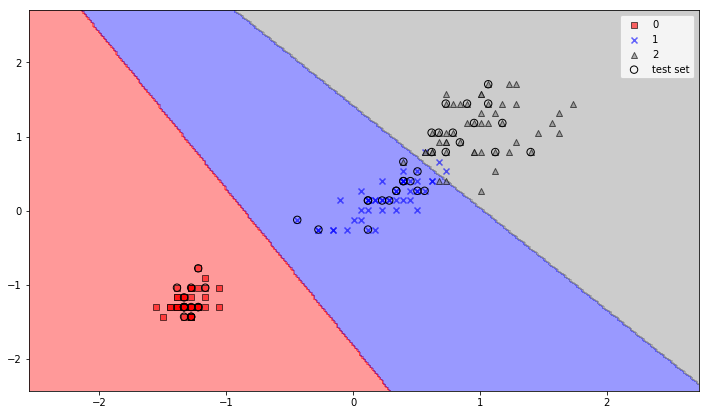

In [7]:
plt.figure(figsize=(12,7))
lr1 = linear_model.LogisticRegression(C=10.**(5), random_state=1)
lr1.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr1, test_idx=range(105, 150))
plt.legend()

As for the overfitting case, we could see for test dataset, there are points mislabeled in the blue area. Comparing with the good case below, it seems the adding more penalty will improve the accuracy, which means the model has learned too much from the training set, thus result in decreasing the accuracy in the test set.

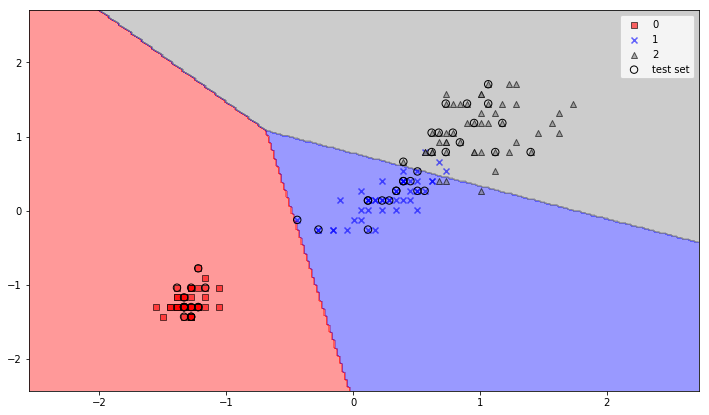

In [8]:
plt.figure(figsize=(12,7))
lr1 = linear_model.LogisticRegression(C=10.**(1), random_state=1)
lr1.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr1, test_idx=range(105, 150))
plt.legend()

# Imbalanced Dataset

In Iris dataset, there are totally 300 data, and for each type, its number is 100.

### Problem statement regarding imbalanced data sets

### Create a sample dataset (The iris dataset seems not to give a good example)

In [9]:
def create_dataset(n_samples=1000, weights=(0.01, 0.01, 0.98), n_classes=3,
                   class_sep=0.8, n_clusters=1):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=0)

In [10]:
## plot
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

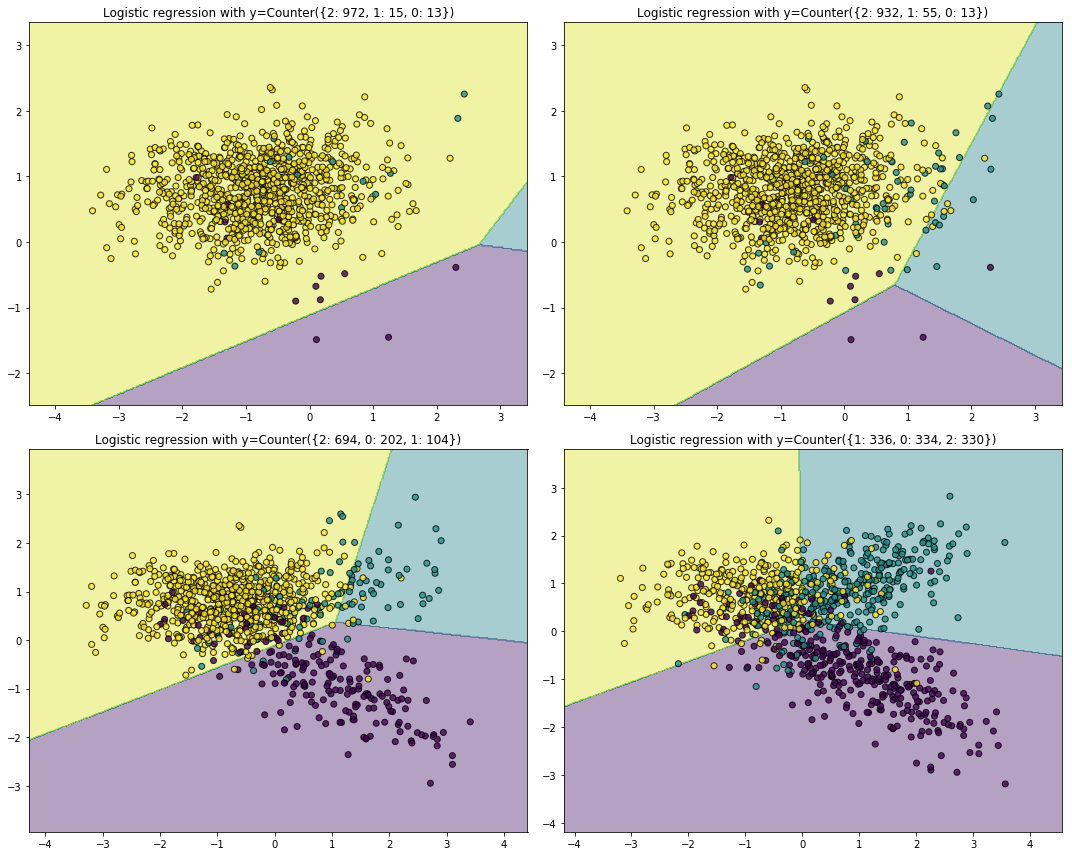

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

ax_arr = (ax1, ax2, ax3, ax4)
weights_arr = ((0.01, 0.01, 0.98), (0.01, 0.05, 0.94),
               (0.2, 0.1, 0.7), (0.33, 0.33, 0.33))
for ax, weights in zip(ax_arr, weights_arr):
    X, y = create_dataset(n_samples=1000, weights=weights)
    clf = linear_model.LogisticRegression().fit(X, y)
    plot_decision_function(X, y, clf, ax)
    ax.set_title('Logistic regression with y={}'.format(Counter(y)))
fig.tight_layout()

As expected, the decision function of the logistic regression is highly impacted. With a greater imbalanced ratio, the decision function favor the class with the larger number of samples, usually referred as the majority class.

## Reference
1. Austin Gilbert, https://github.com/a-gilbert/AML_Nb/blob/master/ML_Libs.ipynb .
2. imbalanced-learn, http://imbalanced-learn.org/en/stable/index.html

In [12]:
X, y = create_dataset(n_samples=1000, weights=(0.33,0.33,0.33))
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,test_size=0.3,
                                                                    random_state=1,
                                                                    stratify=y)
sc = preprocessing.StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

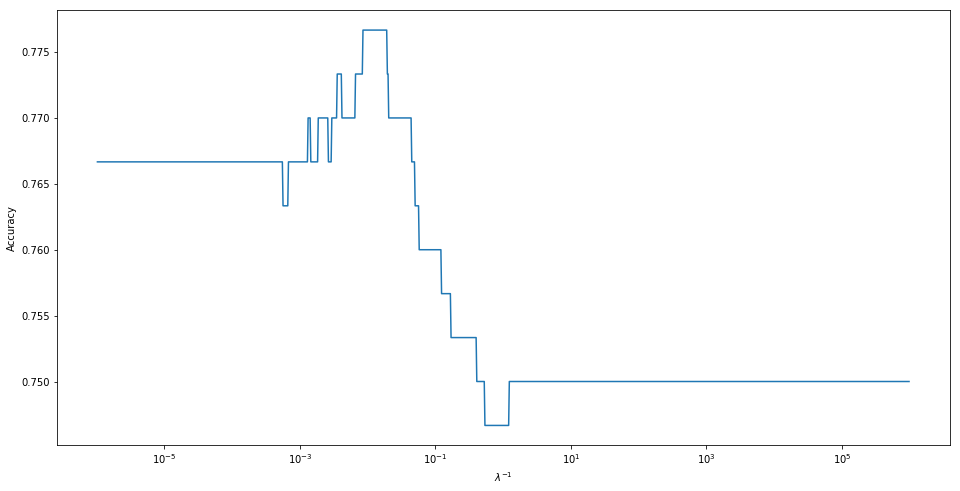

In [13]:
weights, params = [], []
accuracy = []
lrs = []

for c in np.arange(-599, 600)/100:
    lr = linear_model.LogisticRegression(C=10.**c, random_state=1)
    lr.fit(X_train_std, y_train)
    lrs.append(lr)
    weights.append(lr.coef_[1])
    params.append(10.**c)
    y_pred = lr.predict(X_test_std)
    acc = metrics.accuracy_score(y_test, y_pred)
    accuracy.append(acc)

    
weights = np.array(weights)

plt.close('all')
fig, axs= plt.subplots(1, 1, figsize=(16, 8))
plt.subplot(111)
plt.plot(params, accuracy)
plt.xlabel(r'$\lambda^{-1}$')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.show()

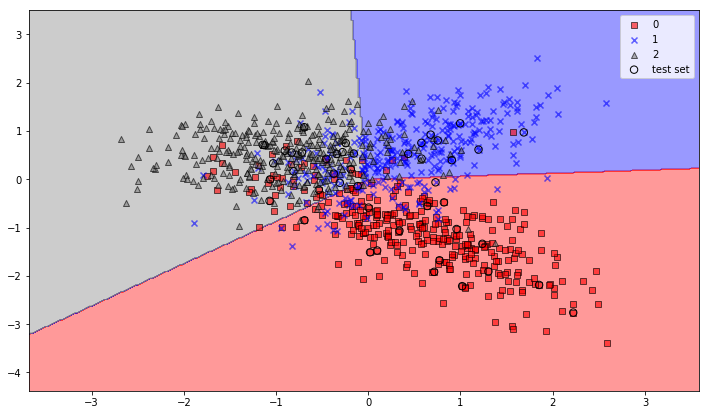

In [14]:
plt.figure(figsize=(12,7))
lr1 = linear_model.LogisticRegression(C=10.**(-5), random_state=1)
lr1.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr1, test_idx=range(105, 150))
plt.legend()

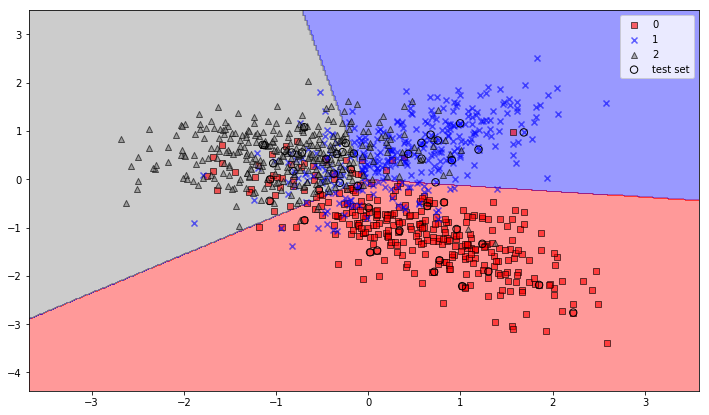

In [15]:
plt.figure(figsize=(12,7))
lr1 = linear_model.LogisticRegression(C=10.**(-2), random_state=1)
lr1.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr1, test_idx=range(105, 150))
plt.legend()

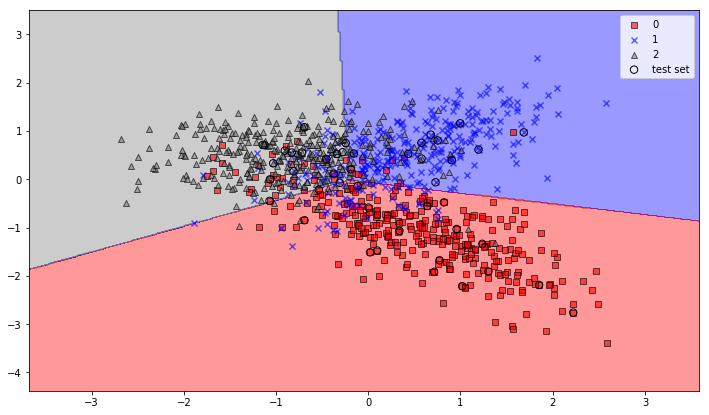

In [16]:
plt.figure(figsize=(12,7))
lr1 = linear_model.LogisticRegression(C=10.**(3), random_state=1)
lr1.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr1, test_idx=range(105, 150))
plt.legend()